### Issue with previous nb code, created new one

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
size=512
path = Path('./')

database = Database()
database.open(str(path/'./databases/MITOS_WSI_CMC_COADEL_TR.sqlite'))

slidelist_test_1 = ['14','18','3','22','10','15','21']
slidelist_test_2 = ['1','20','17','5','2','11','16']
slidelist_test_3 = ['13','7','19','8','6','9', '12']
slidelist_test = slidelist_test_1

## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [2]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, negative_class=1,  size=size,database=database,basepath='./WSI')

Loading slides .. : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.68it/s]


In [3]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

/tmp/ipykernel_302347/208111965.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img2bbox = dict(zip(files, np.array(lbl_bbox)))


In [4]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [5]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [6]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

/home/jmwolf/anaconda3/envs/wsi_eda/lib/python3.10/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


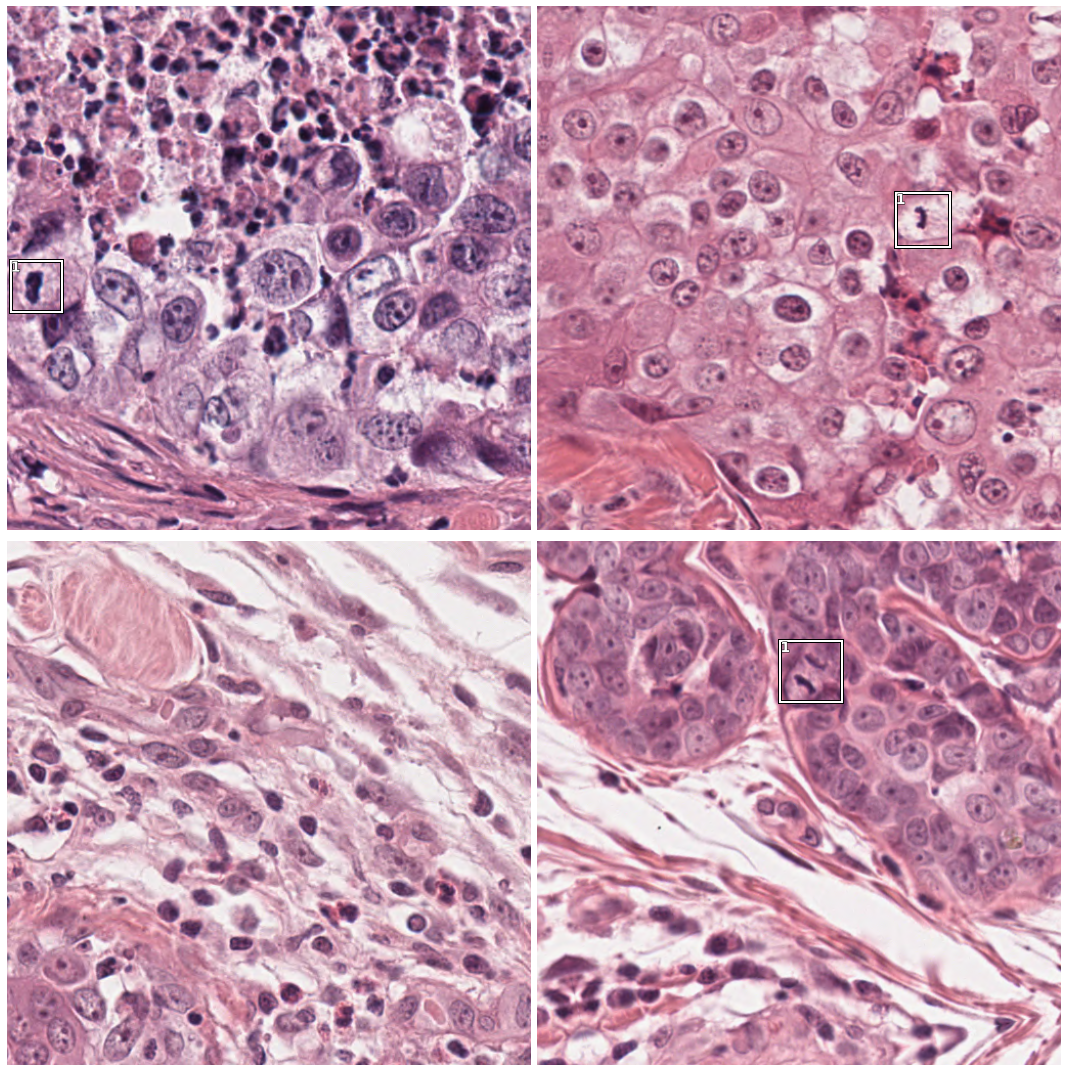

In [7]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(15,15))

In [8]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7,0.8])


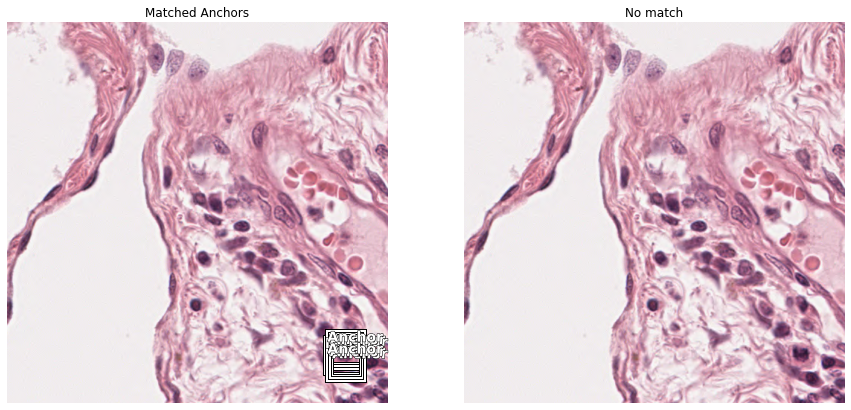

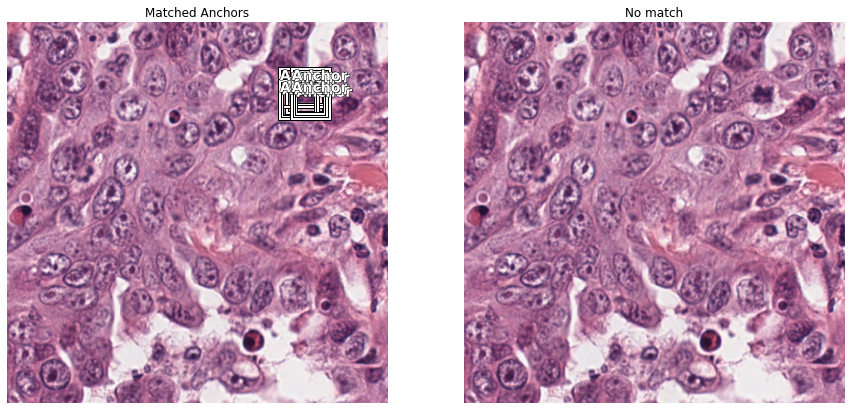

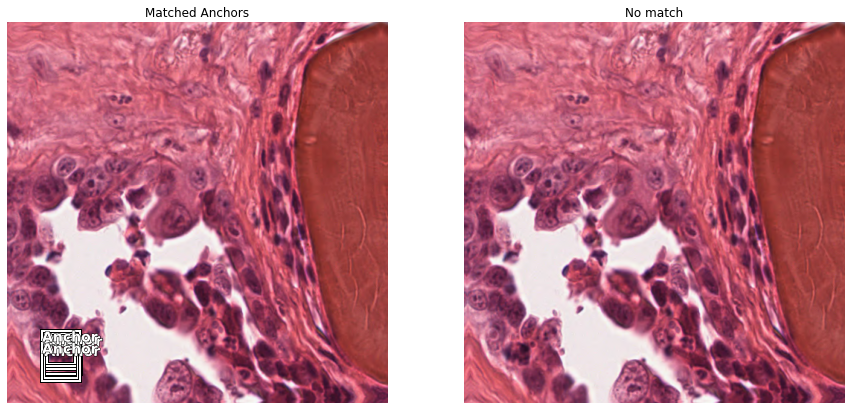

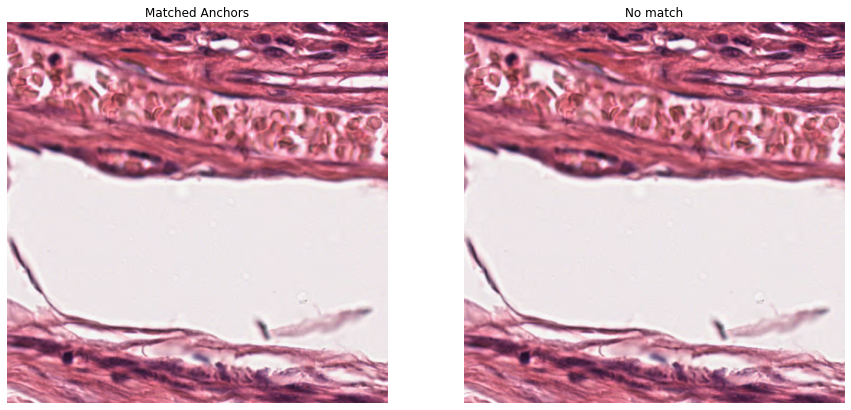

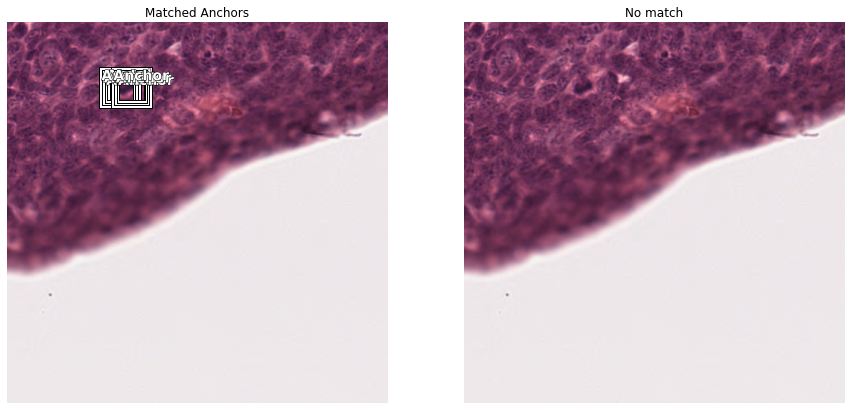

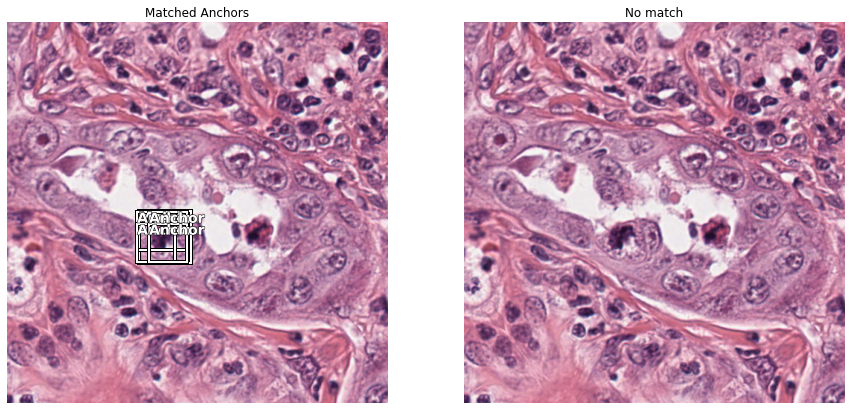

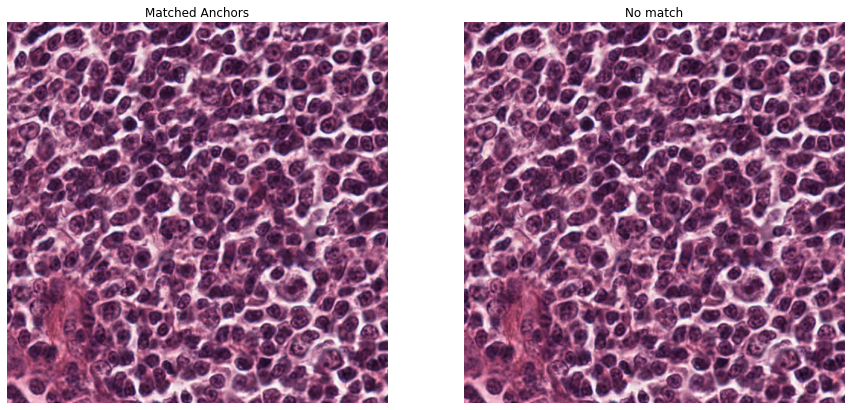

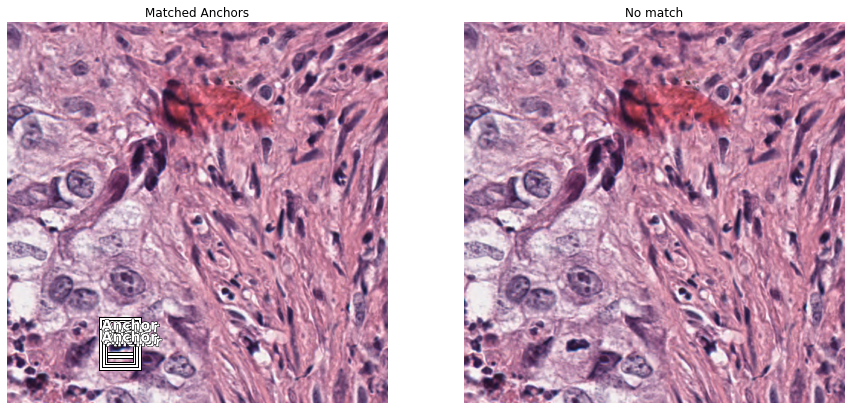

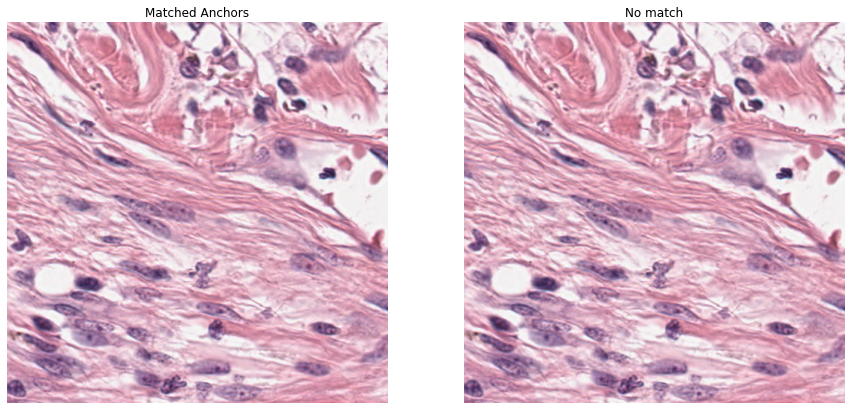

In [9]:
not_found = show_anchors_on_images(data, anchors)

In [10]:
crit = RetinaNetFocalLoss(anchors)

In [11]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)



In [12]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [13]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


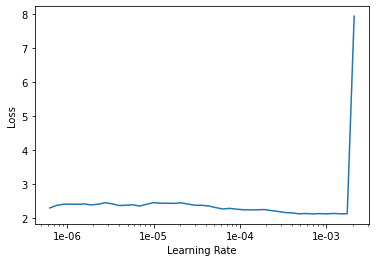

In [14]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2907/2907 [00:00<00:00, 4222.40it/s]


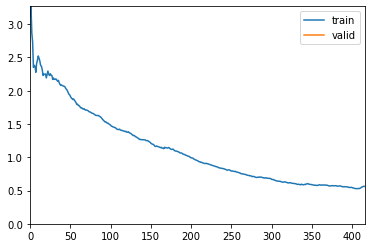

In [15]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:00<00:00, 4644.33it/s]


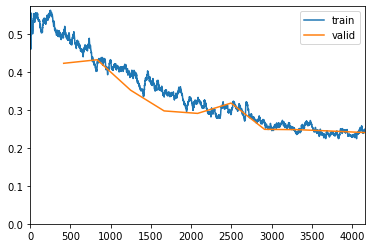

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3081/3081 [00:00<00:00, 4772.82it/s]


In [16]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2945/2945 [00:00<00:00, 4806.78it/s]


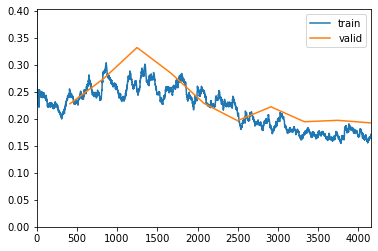

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3105/3105 [00:00<00:00, 4625.87it/s]


In [17]:
learn.unfreeze()
lr=1e-4

learn.fit_one_cycle(10, lr)

GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3112/3112 [00:00<00:00, 4834.53it/s]


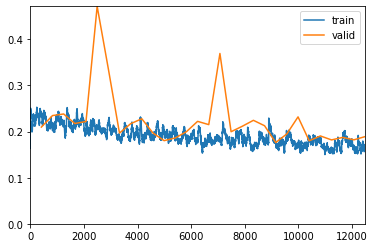

Better model found at epoch 0 with valid_loss value: 0.2097787708044052.


GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3119/3119 [00:00<00:00, 4926.01it/s]


Better model found at epoch 7 with valid_loss value: 0.1967274397611618.


GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3071/3071 [00:00<00:00, 4656.96it/s]


Better model found at epoch 11 with valid_loss value: 0.18031921982765198.


GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3021/3021 [00:00<00:00, 4943.54it/s]


Better model found at epoch 21 with valid_loss value: 0.17624343931674957.


GT: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3039/3039 [00:00<00:00, 4832.11it/s]


In [18]:
learn.unfreeze()
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', name='model')])

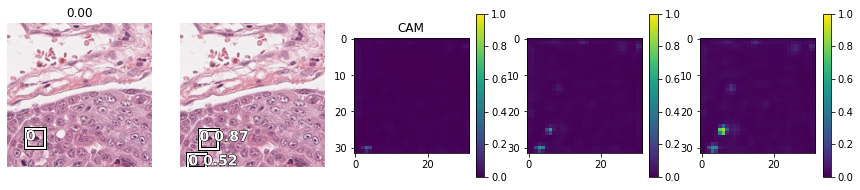

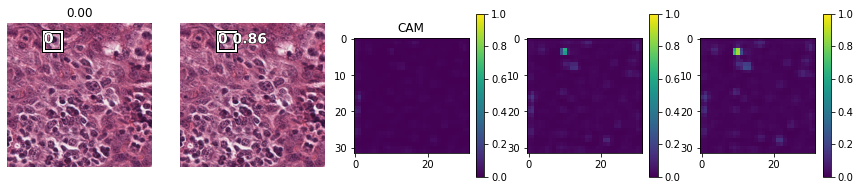

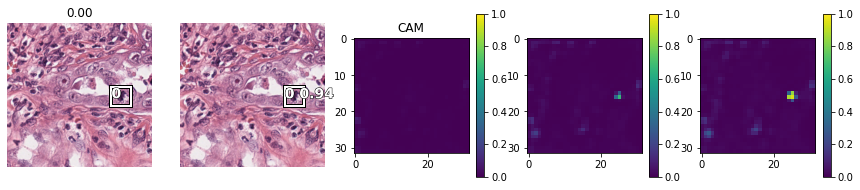

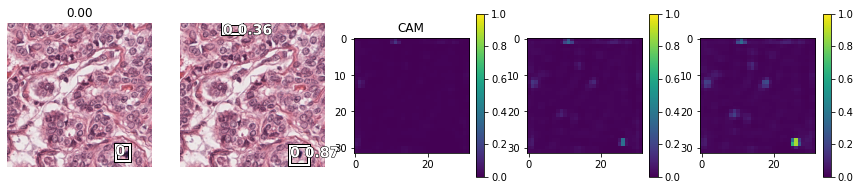

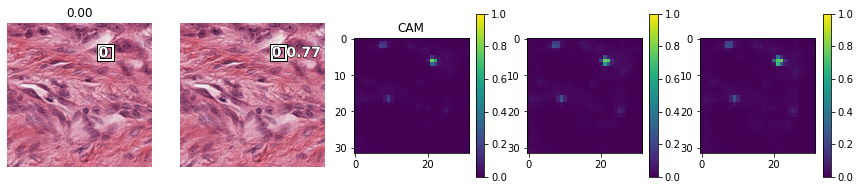

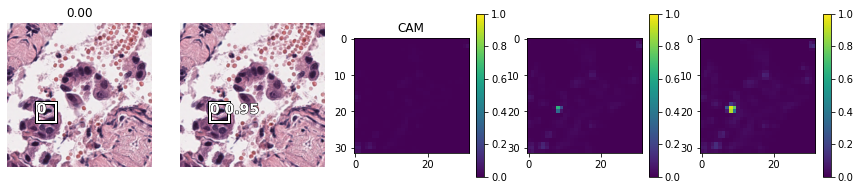

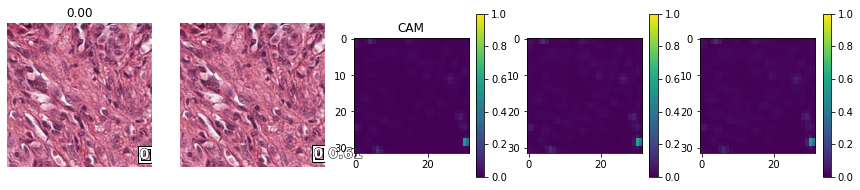

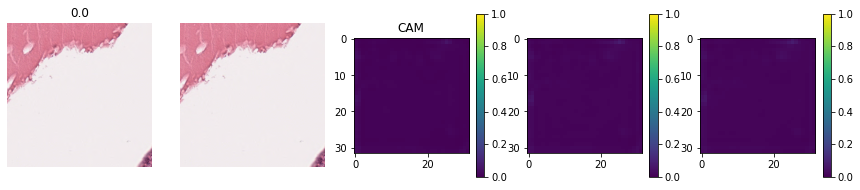

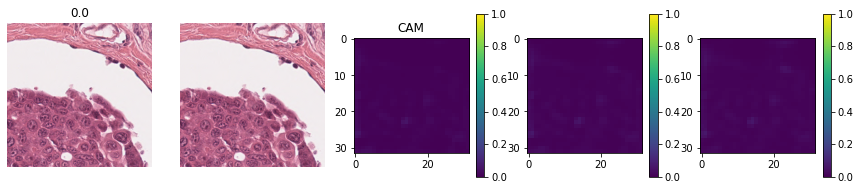

In [19]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [20]:
learn.save('RetinaNet-CMC-COADEL-512sh-batch1', with_opt=True)
learn.export("RetinaNet-CMC-COADEL-512sh-b1.pth")

In [21]:
torch.save(learn.model.state_dict(), "RetinaNet-CMC-COADEL-512sh-batch1_statedict.pth")

In [22]:
learn.data.stats

[tensor([0.7606, 0.5592, 0.6550]), tensor([0.1619, 0.2128, 0.1703])]